# 定向勾选属性关联规则
* 频繁项集查找

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
from impala.dbapi import connect
from impala.util import as_pandas
# import g/c
import json
import pymysql
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
tqdm.pandas(desc="Processing!")

# from script.weight import weights_calcul, weights_assign  # 权值编、解码脚本

## 数据：计划信息+素材信息+运营指标信息
* 计划信息表：含有各计划创建的属性详情（有缺失）；
* 素材信息表：含有各素材的素材ID以及素材标签情况；
* 运营信息表：含有各计划上线跑分的指标情况，只用于后续打标签；

In [2]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

### 采集：计划信息

In [3]:
plan_info = pd.read_csv('/home/data/ch_data/ptom_third_plan.csv')

In [4]:
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2020-01-01'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-04-23'
                                and create_time <= '2021-04-24'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
plan_info_new = get_plan_info()

### 采集：素材信息

In [6]:
image_info = pd.read_csv('/home/data/ch_data/image_info.csv')

In [7]:
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2020-01-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [8]:
image_info_new = get_image_info()

### 采集：运营信息

In [9]:
launch_report = pd.read_csv('/home/data/ch_data/launch_report.csv')

In [10]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= '2020-01-01' 
            AND b.tdate >= '2020-01-01' 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [11]:
launch_report_new = get_launch_report()

### 合并

In [12]:
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type', 'budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'], inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
                           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
                           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
                           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
                           'gender', 'city', 'platform', 'launch_price',
                           'retargeting_tags_exclude', 'interest_categories',
                           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
                           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
                           'action_categories', 'action_days', 'action_scene', 'deep_bid_type']]
    return plan_info

In [13]:
# 计划
plan_info = plan_info.append(plan_info_new)
plan_info = get_plan_json(plan_info)
plan_info.dropna(subset=['cpa_bid'], inplace=True)
# 素材
image_info = image_info.append(image_info_new)
image_info.dropna(subset=['image_id'], inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
# 运营
launch_report = launch_report.append(launch_report_new)

* 拼接+过滤

In [14]:
df = pd.merge(plan_info, image_info, on=['channel_id', 'source_id'], how='left')
df.dropna(subset=['image_id'], inplace=True)
df = pd.merge(df, launch_report, on=['channel_id', 'source_id'], how='left')
df.drop(df[df['tdate'].isna()].index, inplace=True)
df = df[df['amount'] >= 500]

### 字段处理
* ROI指标打标签

In [15]:
df.dropna(subset=['roi'], inplace=True)
df.dropna(subset=['new_role_money'], inplace=True)
df.dropna(subset=['amount'], inplace=True)

In [16]:
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']": 1, "['IOS']": 2})
df['label'] = df.apply(lambda x: 1 if x.new_role_money / x.amount >= 0.001 or x.roi >= 0.001 else 0, axis=1)  # 打标签
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate': 'create_date'}, inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [17]:
df.drop(['channel_id', 'source_id', 'amount', 'roi', 'pay_rate', 'new_role_money'], axis=1, inplace=True)

#### 特殊字段

In [18]:
df = df.mask(df.applymap(str).eq('[]'))  # 空list替换为NaN

In [19]:
df = df.mask(df.applymap(str).eq('NONE'))  # NONE替换为NaN

#### 缺失统计
* 这里的缺失不代表取值不确定，而是没有条件定向的限制，所以不应该过滤

In [20]:
from matplotlib import pyplot as plt

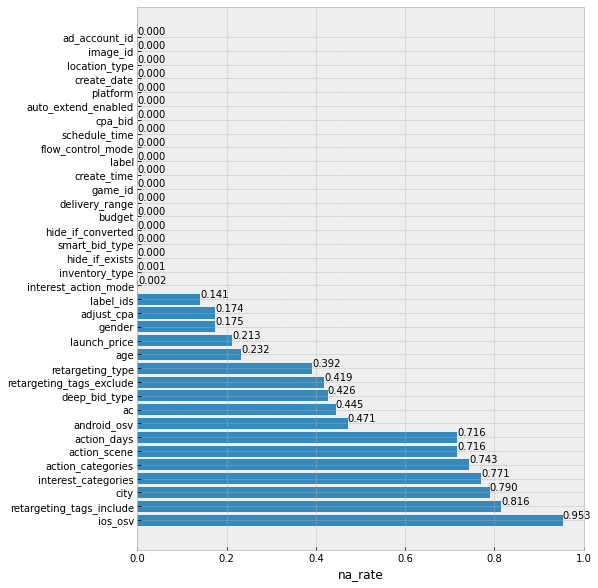

In [21]:
# 各字段缺失率统计
na_rate = (len(df) - df.count()) / len(df)  # 缺失率
a = na_rate.sort_values(ascending=False)  # 倒序
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize = (8,10))
plt.barh(range(df.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.yticks(range(df.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f'%y, va='bottom')

In [22]:
# df.drop(['schedule_time', 'ios_osv', 'retargeting_tags_include', 'city', 'interest_categories', 'action_categories', 'action_scene', 'action_days', 'android_osv', 'ac', 'retargeting_tags_exclude', 'deep_bid_type', 'retargeting_type'], axis=1, inplace=True)  # 删除缺失率超25%的字段
# df.drop_duplicates(inplace=True)  # keep=first

In [23]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155435 entries, 0 to 155434
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ad_account_id             155435 non-null  int64         
 1   game_id                   155435 non-null  int64         
 2   create_time               155435 non-null  datetime64[ns]
 3   smart_bid_type            155435 non-null  object        
 4   hide_if_exists            155435 non-null  int64         
 5   budget                    155435 non-null  float64       
 6   delivery_range            155435 non-null  object        
 7   adjust_cpa                128318 non-null  float64       
 8   inventory_type            155299 non-null  object        
 9   hide_if_converted         155435 non-null  object        
 10  flow_control_mode         155435 non-null  object        
 11  schedule_time             155435 non-null  object        
 12  cp

In [24]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,image_id,label_ids,create_date,label
0,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,NaN,2020-01-21,0
1,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,NaN,2020-01-21,0
2,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,None,2020-01-21,0
3,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,None,2020-01-21,0
4,4003,1000840,2020-01-20 14:35:23,SMART_BID_CONSERVATIVE,0,8000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1180.24,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19791,NaN,2020-01-20,0


In [33]:
df = df[df['label_ids'].notnull() & (df['label_ids'] != '-1') & (df['label_ids'] != '\"-1')]
df['label_ids'] = df['label_ids'].str.replace('-1;', '')
df['label_ids'] = df['label_ids'].str.replace('-1,', '')
df['label_ids'] = df['label_ids'].str.replace('\"', '') 
df['label_ids'] = df['label_ids'].str.replace(';', ',')

In [34]:
df['label_ids'][df['label_ids'].apply(lambda x:True if len(str(x).split(',')) > 1 else False)]

48348            19,103
48349            19,103
48350            19,103
48351            19,103
50176             19,20
              ...      
154094    20,27,111,149
154097    20,27,111,149
154098    20,27,111,149
154101    20,27,111,149
154105    20,27,111,149
Name: label_ids, Length: 782, dtype: object

## 关联规则
* 适用于hotting编码字段（勾选分组）HOTTING_COLS = ['inventory_type', 'age', 'label_ids', 'ac',......]

In [273]:
df_list = df[['inventory_type', 'age', 'label_ids', 'ac', 'interest_categories', 'label']]

In [274]:
df_list_pos = df_list[df_list['label']==1]

In [275]:
def _filter(x):
    return True if isinstance(x, list) else False

def _distinct(x):
    return len(x)

boolea = df_list_pos['age'].apply(_filter)
df_list_pos = df_list_pos[boolea]
prefix = df_list_pos['age'].to_list()

lenth = df_list_pos['age'].apply(_distinct)
distinct = max(lenth)

In [276]:
from prefixspan import PrefixSpan

In [278]:
ps = PrefixSpan(prefix)

In [281]:
for num in range(3):
    ps.minlen = num + 1
    ps.maxlen = num + 1
    # ps.minsup = 0.1
    print('字段 ’age’ Top({}, 频繁项集):'.format(num + 1), ps.topk(3), '\n')

字段 ’age’ Top(1, 频繁项集): [(23523, ['AGE_BETWEEN_31_40']), (23287, ['AGE_BETWEEN_24_30']), (20490, ['AGE_BETWEEN_41_49'])] 

字段 ’age’ Top(2, 频繁项集): [(22709, ['AGE_BETWEEN_24_30', 'AGE_BETWEEN_31_40']), (20203, ['AGE_BETWEEN_31_40', 'AGE_BETWEEN_41_49']), (19734, ['AGE_BETWEEN_24_30', 'AGE_BETWEEN_41_49'])] 

字段 ’age’ Top(3, 频繁项集): [(19455, ['AGE_BETWEEN_24_30', 'AGE_BETWEEN_31_40', 'AGE_BETWEEN_41_49']), (7105, ['AGE_BETWEEN_18_23', 'AGE_BETWEEN_24_30', 'AGE_BETWEEN_31_40']), (5500, ['AGE_BETWEEN_18_23', 'AGE_BETWEEN_31_40', 'AGE_BETWEEN_41_49'])] 

